<a href="https://colab.research.google.com/github/Pumafi/flumy-wgan-mines/blob/main/conditional_multiscalegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSGAN parametric

In [ ]:
# From the git
import sys
sys.path.append('..')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from data.load_data import load_data, DataGenerator
from models.msgan.multiscale_discriminator import get_discriminator_model
from models.msgan.multiscale_gan import MSGAN
from models.msgan.multiscale_generator import MultiScaleGenerator
from utils.callbacks import MSGANMonitor
from utils.utils import generate_noise
from utils.visualisation import get_color_map, visualise_slice, multi_scale_paint_image, \
    show_multi_scale_images_and_probas, show_multi_scale_images

In [5]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Data  
Load the data and create a Data Generator

In [6]:
data_x = np.load("/content/gdrive/MyDrive/conditional_x_8000_vert.npy")
y_train = np.load("/content/gdrive/MyDrive/conditional_y_8000_vert.npy")
print(data_x.shape, y_train.shape)

(8000, 64, 128) (8000, 2)


In [33]:
# Data sizes specifications
slice_size = (64, 128, 9)
batch_size = 20
noise_shape = (8, 16)

ncategories = int(data_x.max())
nsamples = data_x.shape[0]

# data = data_x.transpose((1, 0))
#reshaped_data = data_x.reshape((nsamples, nrows, ncols))
one_hot = np.eye(ncategories, dtype='float32')[data_x - 1]

x_train = one_hot.reshape((nsamples, *slice_size))
print(data_x.shape)

(8000, 64, 128)


In [8]:
import tensorflow as tf

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, datax, datay, batch_size=32, dim=(64, 64, 4), shuffle=True):
        self.datax = datax
        self.datay = datay
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.datax) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            shuffler = np.random.permutation(len(self.datax))
            #np.random.shuffle(self.data)
            self.datax = self.datax[shuffler]
            self.datay = self.datay[shuffler]

    def __getitem__(self, index):
        X = self.datax[index * self.batch_size:(index + 1) * self.batch_size]
        Y = self.datay[index * self.batch_size:(index + 1) * self.batch_size]
        return X, Y

In [10]:
# Loading the data
# x_train = load_data(slice_size[0], slice_size[1], "../conditional_x_5500_vert.npy")
dataloader = DataGenerator(x_train, y_train, batch_size, slice_size)

# Colors map for data visualisation
cmap, norm = get_color_map(number_of_categories=9)

In [11]:
import tensorflow as tf


def pix_norm(x, epsilon=1e-8):
    scale = tf.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)
    return x / scale

@tf.function
def conditional_convolution(input, filters):
    # Pre-Treatement
    #output = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(input)
    
    # Core
    output_list = []
    #print(output.shape)
    for b in range(input.shape[0]):
        output_list.append(tf.nn.depthwise_conv2d(tf.expand_dims(input[b], axis=0), tf.expand_dims(filters[b], axis=-1), strides=[1, 1, 1, 1], padding='SAME'))

    outputs = tf.stack(output_list)
    # Return
    return tf.squeeze(outputs, axis=1)

class GeneratorInitial(tf.keras.layers.Layer):
    # First layer of the Multi-Scale Generator
    # It is a simple convolution, but without skip connection, 256 channels and a large kernel size
    def __init__(self, features, output_features=256, kernel_size=(9, 9), padding="valid"):
        super(GeneratorInitial, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=output_features, kernel_size=kernel_size,
                                           strides=(1, 1), activation="relu", padding=padding, name="gen-init-conv")
        
        self.conv2 = tf.keras.layers.Conv2D(filters=output_features, kernel_size=kernel_size,
                                           strides=(1, 1), activation="relu", padding=padding, name="gen-init-conv2")
        
        self.fc = tf.keras.layers.Dense(128, activation="selu")
        #self.embedding = tf.keras.layers.Embedding(8, 16)
        self.reshape = tf.keras.layers.Reshape((1, 1, -1))

        self.conv_condi = tf.keras.layers.Conv2DTranspose(filters=output_features, kernel_size=(3, 3), strides=(3, 3), activation="selu", padding="same")
        
        #self.concat = tf.keras.layers.Concatenate(axis=-1)

    def call(self, inputs):
        input_noise = inputs[0]
        input_cond = inputs[1]
        y = self.conv(input_noise)
        

        condition = self.fc(input_cond)
        #condition = self.embedding(condition)
        condition = self.reshape(condition)
        condition = self.conv_condi(condition)
        #print(condition.shape)

        #y = self.concat([y, condition])
        y = conditional_convolution(y, condition)
        y = self.conv2(y)
        y = pix_norm(y)

        return y


class GeneratorBlock(tf.keras.layers.Layer):
    # Intermediate layers of the Multi-Scale Generator
    # This block has: One upsampling layer, two convolutions,
    # one skip connections and a Pixel-Wise Normalisation
    def __init__(self, features, output_features, upsampling_size=(2, 2), kernel_size=(3, 3), padding="valid", name="gen-block"):
        super(GeneratorBlock, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=upsampling_size,
                                                     interpolation='nearest',
                                                     name=name + "-upsampling")

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv2")

        self.conv_skip = tf.keras.layers.Conv2D(filters=output_features, kernel_size=(1, 1),
                                                strides=(1, 1), padding=padding,
                                                activation="softmax", name=name + "-skip-conv")

    def call(self, inputs):
        y = self.upsample(inputs)
        y = self.conv_1(y)
        y = pix_norm(y)
        y = self.conv_2(y)
        y = pix_norm(y)

        y_prime = self.conv_skip(y)

        return y, y_prime


class LastGeneratorBlock(tf.keras.layers.Layer):
    # Last block of the Multi-Scale Generator model
    # Same as intermediate blocks, but without the last pix-norm and obviously without skip connection
    # The resizing method is also changed to bilinear for a smoother result
    def __init__(self, features, output_features, kernel_size=(3, 3), upsampling=(2, 2), padding="valid", name="gen-fin-block"):
        super(LastGeneratorBlock, self).__init__()
        self.upsample = tf.keras.layers.UpSampling2D(size=upsampling,
                                                     interpolation='bilinear',
                                                     name=name + "-upsampling")

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=output_features, kernel_size=kernel_size,
                                             strides=(1, 1), padding="same", activation="softmax",
                                             name=name + "-final-conv")

    def call(self, inputs):
        # Conv
        y = self.upsample(inputs)
        y = self.conv_1(y)
        y = pix_norm(y)
        y = self.conv_2(y)

        return y


class MultiScaleGenerator(tf.keras.Model):
    def __init__(self, output_dims, kernel_size=(3, 3), layers_features=None):
        """
        Generator class for Multi-Scale model
        Args:
            output_dims: tuple (h, w, c) giving the dimensions
            kernel_size: dimension of convolution kernels
        """
        super(MultiScaleGenerator, self).__init__()
        if layers_features is None:
            layers_features = [256, 64, 32, 16, 4]
        padding = "same"
        output_features = output_dims[-1]

        self.block_1 = GeneratorInitial(layers_features[0], output_features, kernel_size=kernel_size, padding=padding)
        self.block_2 = GeneratorBlock(layers_features[1], output_features, upsampling_size=(1, 1),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-1")
        self.block_3 = GeneratorBlock(layers_features[2], output_features, upsampling_size=(2, 2),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-2")
        self.block_4 = GeneratorBlock(layers_features[3], output_features, upsampling_size=(2, 2),
                                      kernel_size=kernel_size, padding=padding, name="gen-block-3")
        self.block_5 = LastGeneratorBlock(layers_features[-1], output_features, kernel_size=kernel_size, padding=padding)

        self.generator_blocks = [self.block_1, self.block_2, self.block_3, self.block_4, self.block_5]

    def call(self, inputs):
        outputs = []
        y = self.block_1(inputs)

        for i in range(1, len(self.generator_blocks) - 1):
            y, y_prime = self.generator_blocks[i](y)
            outputs.append(y_prime)

        y = self.generator_blocks[-1](y)
        outputs.append(y)

        # [(8, 16, 4), (16, 32, 4), ... (64, 128, 4)]
        return outputs


In [12]:
# Creating the Generator Model
g_model = MultiScaleGenerator(output_dims=slice_size)
#g_model.build([None, *noise_shape, 1])
#g_model.build()
generator_optimizer = keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.99)
#g_model.summary()

In [13]:
x_ex = random_latent_vectors = generate_noise(1, 8, 16, 1)
y_ex = y_train[:3]

In [14]:
print(y_ex.shape)

(3, 2)


In [15]:
res = g_model((x_ex, y_ex))
g_model.summary()

Model: "multi_scale_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial (Generato  multiple                 11589     
 rInitial)                                                       
                                                                 
 generator_block (GeneratorB  multiple                 42761     
 lock)                                                           
                                                                 
 generator_block_1 (Generato  multiple                 28009     
 rBlock)                                                         
                                                                 
 generator_block_2 (Generato  multiple                 7097      
 rBlock)                                                         
                                                                 
 last_generator_block (LastG  multiple       

In [16]:
import tensorflow as tf
from tensorflow import keras


class MinibatchStdev(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # calculate the mean standard deviation across each pixel coord
    def call(self, inputs):
        mean = tf.keras.backend.mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = tf.keras.backend.mean(tf.keras.backend.square(inputs - mean), axis=0, keepdims=True) + 1e-8
        mean_pix = tf.keras.backend.mean(tf.keras.backend.sqrt(mean_sq_diff), keepdims=True)
        shape = tf.keras.backend.shape(inputs)
        output = tf.keras.backend.tile(mean_pix, [shape[0], shape[1], shape[2], 1])
        return tf.keras.backend.concatenate([inputs, output], axis=-1)

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)


class InitialDiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size=(3, 3), avg_pooling=(2, 2), padding="same", name="initial-disc-block"):
        super(InitialDiscriminatorBlock, self).__init__()

        self.noise = tf.keras.layers.GaussianNoise(1.0)

        self.from_categ = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                                 strides=(1, 1), padding=padding, name=name + "-from-categories")

        self.mstd = MinibatchStdev()

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv2")

        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=avg_pooling, padding="valid",
                                                         name=name + "-avg-pool")
        
        self.fc = tf.keras.layers.Dense(2048, activation="selu")
        #self.embedding = tf.keras.layers.Embedding(32, 64)
        self.reshape = tf.keras.layers.Reshape((32, 64, 1))
        self.conv_condi = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                                 strides=(1, 1), activation="selu", padding=padding, name="conditional-init-conv")
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)

    def call(self, inputs):
        input_img = inputs[0]
        input_cond = inputs[1]

        y = self.noise(input_img)
        y = self.from_categ(y)
        y = self.mstd(y)
        y = self.conv_1(y)
        y = self.conv_2(y)
        y = self.avg_pool(y)

        condition = self.fc(input_cond)
        #condition = self.embedding(condition)
        condition = self.reshape(condition)
        condition = self.conv_condi(condition)

        y = self.concat([y, condition])

        return y


class DiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size=(3, 3), avg_pooling=(2, 2), padding="same", name="inter-disc-block"):
        super(DiscriminatorBlock, self).__init__()

        self.concat = tf.keras.layers.Concatenate(axis=-1)

        self.mstd = MinibatchStdev()

        self.noise = tf.keras.layers.GaussianNoise(1.0)


        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv2")

        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=avg_pooling, padding="valid",
                                                         name=name + "-avg-pool")

    def call(self, inputs):
        # Assert type ?
        assert isinstance(inputs, tuple)

        input_x = inputs[0]
        input_rgb = self.noise(inputs[1])

        y = self.concat([input_x, input_rgb])
        y = self.mstd(y)
        y = self.conv_1(y)
        y = self.conv_2(y)
        y = self.avg_pool(y)

        return y


class FinalDiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size_1=(3, 3), kernel_size_2=(4, 4), padding="same", name="final-disc-block"):
        super(FinalDiscriminatorBlock, self).__init__()

        self.mstd = MinibatchStdev()

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size_1,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size_2,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             name=name + "-conv2")

        self.flat = tf.keras.layers.Flatten(name="disc-flatten-output")
        self.dense = tf.keras.layers.Dense(1, name="disc-dense-output", activation="sigmoid")

    def call(self, inputs):
        y = self.mstd(inputs)
        y = self.conv_1(y)
        y = self.conv_2(y)
        y = self.flat(y)
        y = self.dense(y)

        return y


def get_discriminator_model(input_dims, kernel_size=(3, 3), layers_features=None):
    if layers_features is None:
        layers_features = [16, 32, 64, 128, 256]

    padding = "same"

    cond_input = tf.keras.layers.Input(shape=(2,))

    x_high_res = tf.keras.layers.Input(shape=(input_dims[0], input_dims[1], input_dims[2]))
    x_3 = tf.keras.layers.Input(shape=(int(input_dims[0] / 2), int(input_dims[1] / 2), input_dims[2]))
    x_2 = tf.keras.layers.Input(shape=(int(input_dims[0] / 4), int(input_dims[1] / 4), input_dims[2]))
    x_1 = tf.keras.layers.Input(shape=(int(input_dims[0] / 8), int(input_dims[1] / 8), input_dims[2]))

    block_input = (x_high_res, cond_input)
    y = InitialDiscriminatorBlock(layers_features[0], kernel_size=kernel_size)(block_input)
    block_input = (y, x_3)
    y = DiscriminatorBlock(layers_features[1], kernel_size=kernel_size, padding=padding, name="disc-block-1")(
        block_input)
    block_input = (y, x_2)
    y = DiscriminatorBlock(layers_features[2], kernel_size=kernel_size, padding=padding, name="disc-block-2")(
        block_input)
    block_input = (y, x_1)
    y = DiscriminatorBlock(layers_features[3], kernel_size=kernel_size, padding=padding, avg_pooling=(1, 1),
                           name="disc-block-3")(block_input)
    block_input = y
    y = FinalDiscriminatorBlock(layers_features[4], kernel_size_1=kernel_size, padding=padding)(block_input)

    d_model = keras.models.Model([cond_input, x_1, x_2, x_3, x_high_res], y, name="discriminator")
    return d_model


In [17]:
# Creating the Discriminator Model
multiscale = (64, 128, 9)

d_model = get_discriminator_model(multiscale)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.5, beta_2=0.99)
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 128, 9)  0           []                               
                                ]                                                                 
                                                                                                  
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 initial_discriminator_block (I  (None, 32, 64, 32)  12400       ['input_2[0][0]',                
 nitialDiscriminatorBlock)                                        'input_1[0][0]']                
                                                                                      

In [18]:
# Callback
#callback = MSGANMonitor(noise_shape, cmap, norm, slice_size[0], slice_size[1])

In [19]:
import tensorflow as tf
from tensorflow import keras
from utils.utils import generate_noise
from tensorflow import image

tf.config.run_functions_eagerly(True)


def discriminator_loss(real_img, fake_img):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_img), real_img)
    fake_loss = cross_entropy(tf.zeros_like(fake_img), fake_img)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_img):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_img), fake_img)


class CMSGAN(keras.Model):
    """
    WGAN2D (Wasserstein Generative Adversarial Network) model with Gradient Penalty Training
    """

    def __init__(
            self,
            discriminator,
            generator,
            latent_shape,
            discriminator_extra_steps=3,
            generator_extra_steps=1,
            gp_weight=10.0,
            real_image_resize_method=image.ResizeMethod.BILINEAR
    ):
        super(CMSGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_shape = latent_shape
        self.d_steps = discriminator_extra_steps
        self.g_steps = generator_extra_steps
        self.gp_weight = gp_weight
        self.real_image_resize_method = real_image_resize_method

    def compile(self, d_optimizer, g_optimizer, d_loss_fn=discriminator_loss, g_loss_fn=generator_loss):
        super(CMSGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @tf.function
    def call(self, x):
        return None
        """print("CALL 0")
        print(x.shape)
        real_images = x[0]
        conditions = x[1]
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = generate_noise(batch_size, self.latent_shape[0], self.latent_shape[1],
                                               self.latent_shape[-1])
        gen_inputs = (random_latent_vectors, conditions)
        generated_images = self.generator(random_latent_vectors, training=True)
        rint("CALL 1")
        return generated_images"""

    @tf.function
    def train_step(self, ground_truth):
        
        real_images = ground_truth[0]
        conditions = ground_truth[1]
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        x_1 = tf.image.resize(real_images, [self.latent_shape[0], self.latent_shape[1]],
                              method=self.real_image_resize_method)
        x_2 = tf.image.resize(real_images, [self.latent_shape[0] * 2, self.latent_shape[1] * 2],
                              method=self.real_image_resize_method)
        x_3 = tf.image.resize(real_images, [self.latent_shape[0] * 4, self.latent_shape[1] * 4],
                              method=self.real_image_resize_method)
        x_high_res = tf.image.resize(real_images, [self.latent_shape[0] * 8, self.latent_shape[1] * 8],
                                     method=self.real_image_resize_method)

        real_images = [conditions, x_1, x_2, x_3, x_high_res]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = generate_noise(batch_size, self.latent_shape[0], self.latent_shape[1],
                                                   self.latent_shape[-1])
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                gen_inputs = (random_latent_vectors, conditions)
                fake_images = self.generator(gen_inputs, training=True)
                # Get the logits for the fake images
                fake_images = [conditions, *fake_images]
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_loss = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        for i in range(self.g_steps):
            random_latent_vectors = generate_noise(batch_size, self.latent_shape[0], self.latent_shape[1],
                                                   self.latent_shape[-1])
            with tf.GradientTape() as tape:
                gen_inputs = (random_latent_vectors, conditions)
                # Generate fake images using the generator
                generated_images = self.generator(gen_inputs, training=True)
                # Get the discriminator logits for fake images
                generated_images = [conditions, *generated_images]
                gen_img_logits = self.discriminator(generated_images, training=True)
                # Calculate the generator loss
                g_loss = self.g_loss_fn(gen_img_logits)

            # Get the gradients w.r.t the generator loss
            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            # Update the weights of the generator using the generator optimizer
            self.g_optimizer.apply_gradients(
                zip(gen_gradient, self.generator.trainable_variables)
            )

        return {"d_loss": d_loss, "g_loss": g_loss}


In [20]:
# Creating the model
msgan = CMSGAN(
    discriminator=d_model,
    generator=g_model,
    latent_shape=(*noise_shape, 1),
    discriminator_extra_steps=2,
    generator_extra_steps=2
)

In [21]:
# Training the model
epochs = 100

msgan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer)

history = msgan.fit(dataloader, batch_size=batch_size, epochs=epochs, callbacks=[])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


400/400 [==============================] - 235s 586ms/step - d_loss: 0.9999 - g_loss: 2.4861
Epoch 2/100
400/400 [==============================] - 236s 590ms/step - d_loss: 0.7234 - g_loss: 4.4364
Epoch 3/100
400/400 [==============================] - 237s 593ms/step - d_loss: 0.8771 - g_loss: 2.6217
Epoch 4/100
400/400 [==============================] - 234s 586ms/step - d_loss: 0.9465 - g_loss: 2.1308
Epoch 5/100
400/400 [==============================] - 234s 585ms/step - d_loss: 0.9108 - g_loss: 1.7723
Epoch 6/100
400/400 [==============================] - 233s 582ms/step - d_loss: 0.9258 - g_loss: 1.6672
Epoch 7/100
400/400 [==============================] - 233s 582ms/step - d_loss: 0.8117 - g_loss: 1.9709
Epoch 8/100
400/400 [==============================] - 233s 582ms/step - d_loss: 0.7888 - g_loss: 2.2214
Epoch 9/100
400/400 [==============================] - 234s 584ms/step - d_loss: 0.7655 - g_loss: 2.3071
Epoch 10/100
400/400 [==============================] - 233s 582ms/

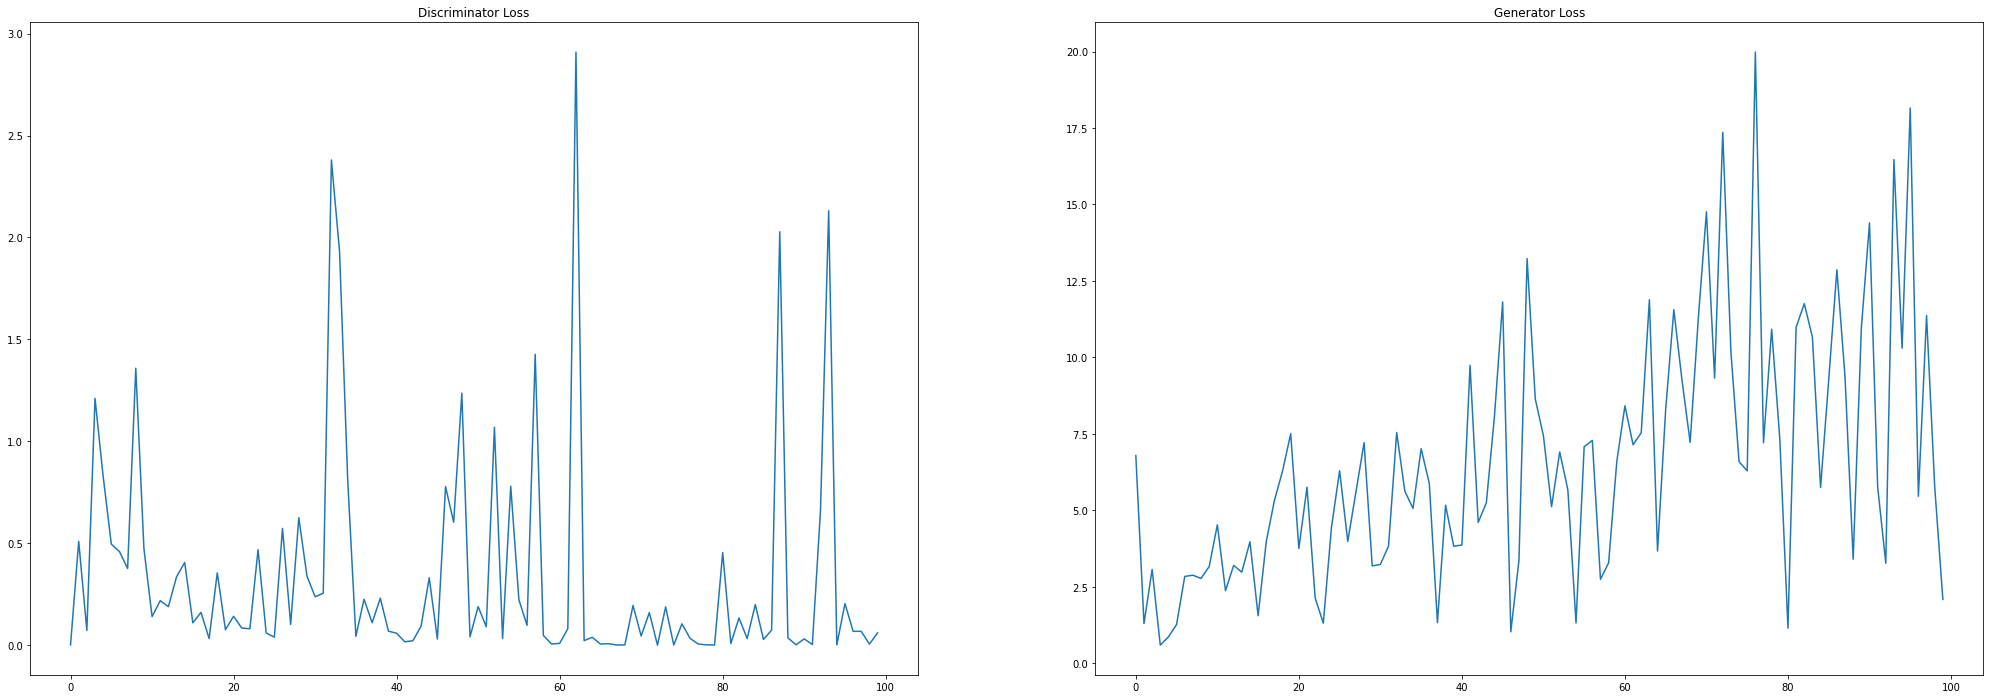

In [22]:
# Error plotting
x_axis = np.arange(epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 2, 1)
plt.title("Discriminator Loss")
plt.plot(x_axis, history.history["d_loss"])
plt.subplot(1, 2, 2)
plt.title("Generator Loss")
plt.plot(x_axis, history.history["g_loss"])
plt.show()

In [23]:
print(y_train.shape)

(8000, 2)


In [24]:
print(y_train[0].shape)

(2,)


In [25]:
y_train[0]

array([57, 59])

In [26]:
from utils.visualisation import show_multi_scale_images

In [27]:
def show_multi_scale_images(array_img, cmap, norm, img_dim, i=0, epoch=0, save_img=False):
    plt.figure(figsize=(120, 20))
    plt.axis('off')
    plt.subplot(1, 4, 1)
    plt.imshow(np.argmax(array_img[-1].numpy(), axis=-1).reshape(img_dim), interpolation='nearest', cmap=cmap,
               norm=norm)
    plt.subplot(1, 4, 2)
    plt.imshow(np.argmax(array_img[2].numpy(), axis=-1).reshape((img_dim[0] // 2, img_dim[1] // 2)),
               interpolation='nearest', cmap=cmap, norm=norm)
    plt.subplot(1, 4, 3)
    plt.imshow(np.argmax(array_img[1].numpy(), axis=-1).reshape((img_dim[0] // 4, img_dim[1] // 4)),
               interpolation='nearest', cmap=cmap, norm=norm)
    plt.subplot(1, 4, 4)
    plt.imshow(np.argmax(array_img[0].numpy(), axis=-1).reshape((img_dim[0] // 8, img_dim[1] // 8)),
               interpolation='nearest', cmap=cmap, norm=norm)

    if save_img:
        plt.savefig("fixed_generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
        plt.close()
    else:
        plt.show()

Conditions [[57 59]]


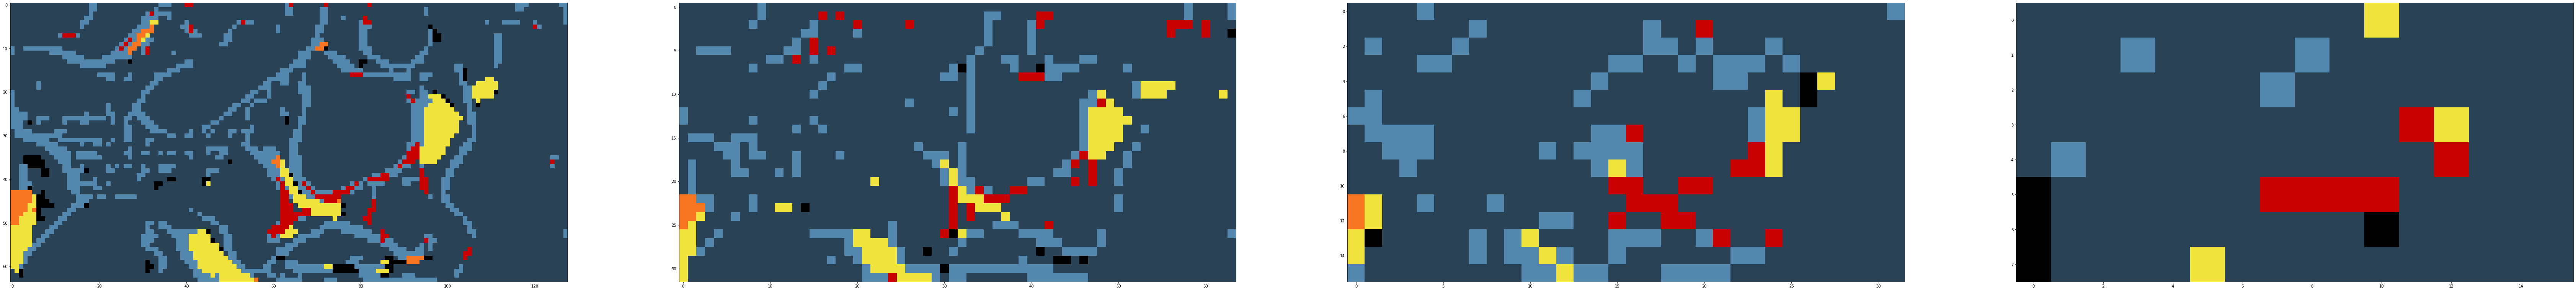

Conditions [[57 59]]


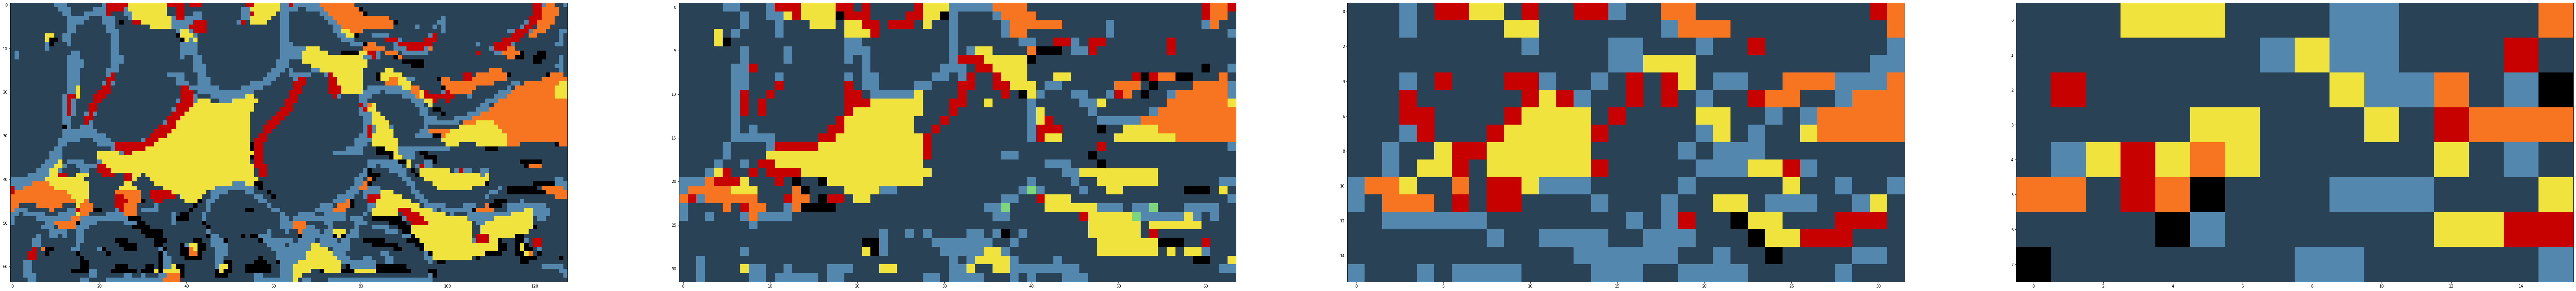

Conditions [[57 59]]


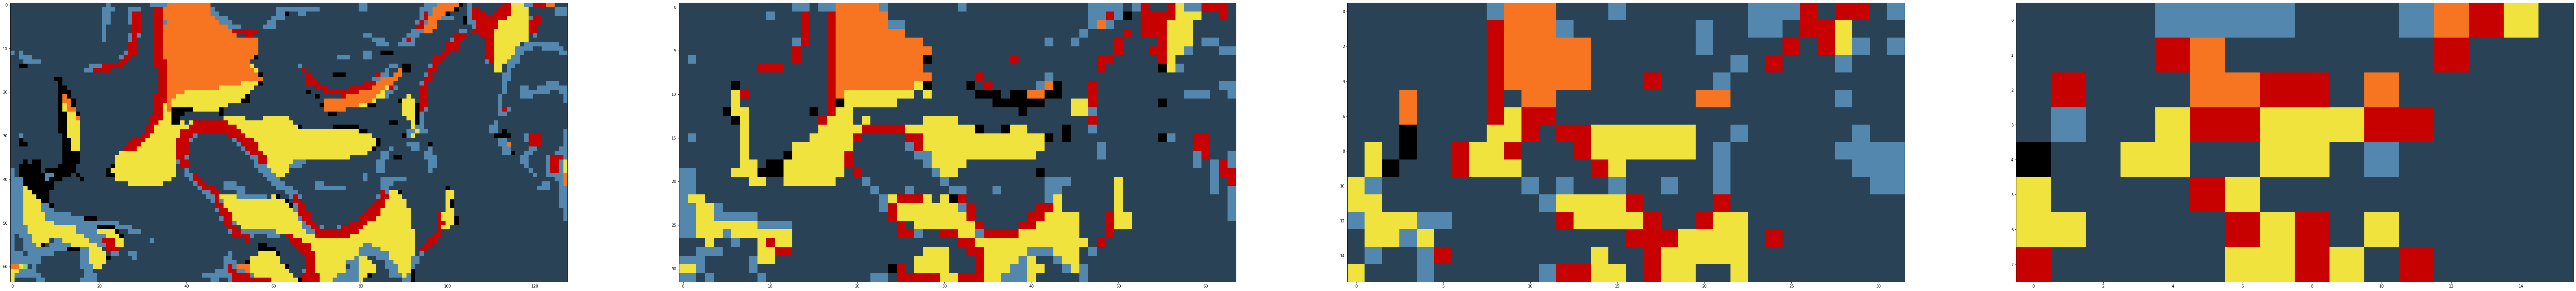

Conditions [[105  28]]


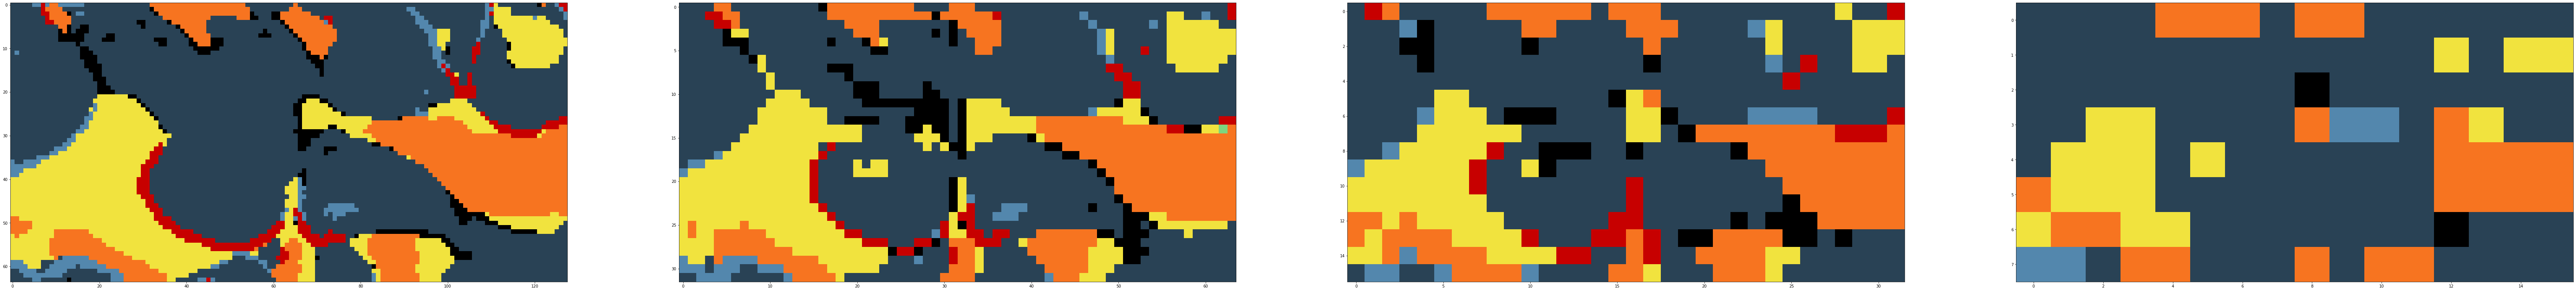

In [35]:
random_latent_vectors = generate_noise(1, *noise_shape, 1)
y_test = np.expand_dims(y_train[0], axis=0)
print("Conditions", y_test)
gen_inputs = (random_latent_vectors, y_test)
generated_images = g_model(gen_inputs, training=True)
show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(64, 128))

random_latent_vectors = generate_noise(1, *noise_shape, 1)
y_test = np.expand_dims(y_train[1], axis=0)
print("Conditions", y_test)
gen_inputs = (random_latent_vectors, y_test)
generated_images = g_model(gen_inputs, training=True)
show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(64, 128))

random_latent_vectors = generate_noise(1, *noise_shape, 1)
y_test = np.expand_dims(y_train[0], axis=0)
print("Conditions", y_test)
gen_inputs = (random_latent_vectors, y_test)
generated_images = g_model(gen_inputs, training=True)
show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(64, 128))



random_latent_vectors = generate_noise(1, *noise_shape, 1)
y_test = np.expand_dims(y_train[25], axis=0)
print("Conditions", y_test)
gen_inputs = (random_latent_vectors, y_test)
generated_images = g_model(gen_inputs, training=True)
show_multi_scale_images(generated_images, cmap=cmap, norm=norm, img_dim=(64, 128))

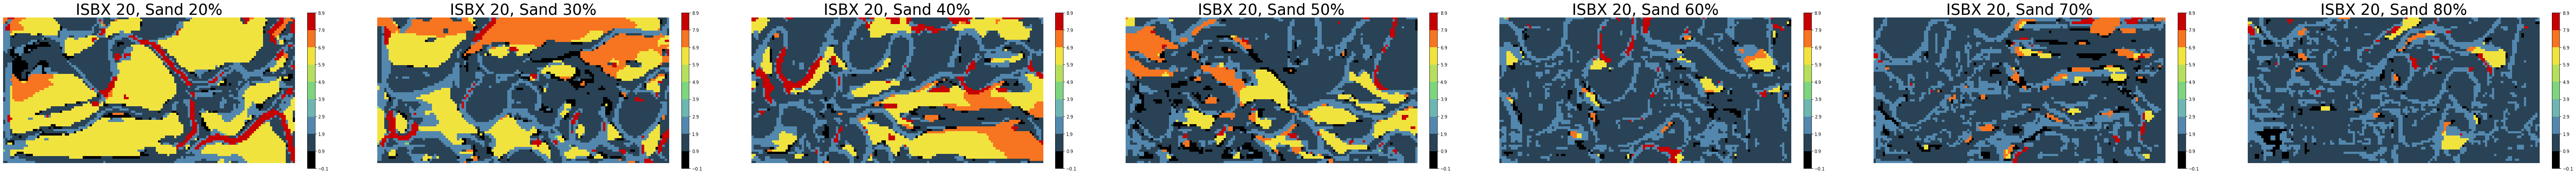

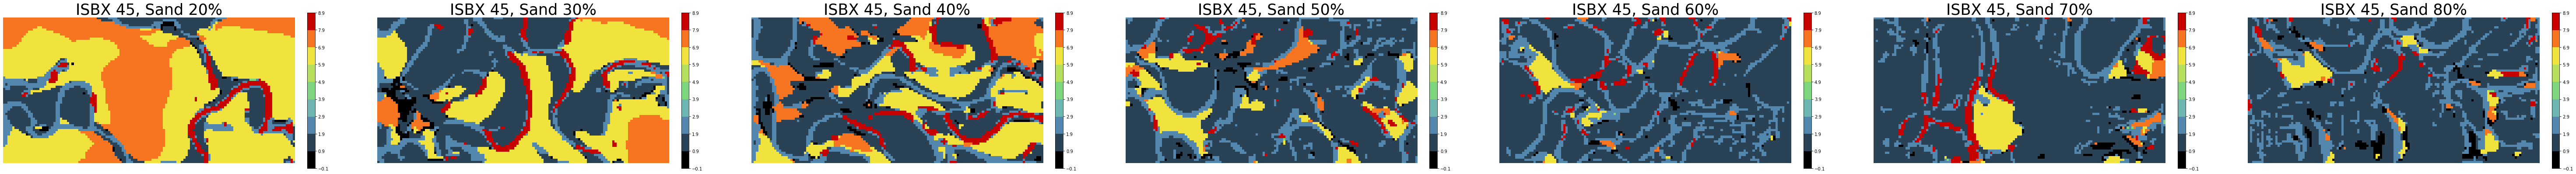

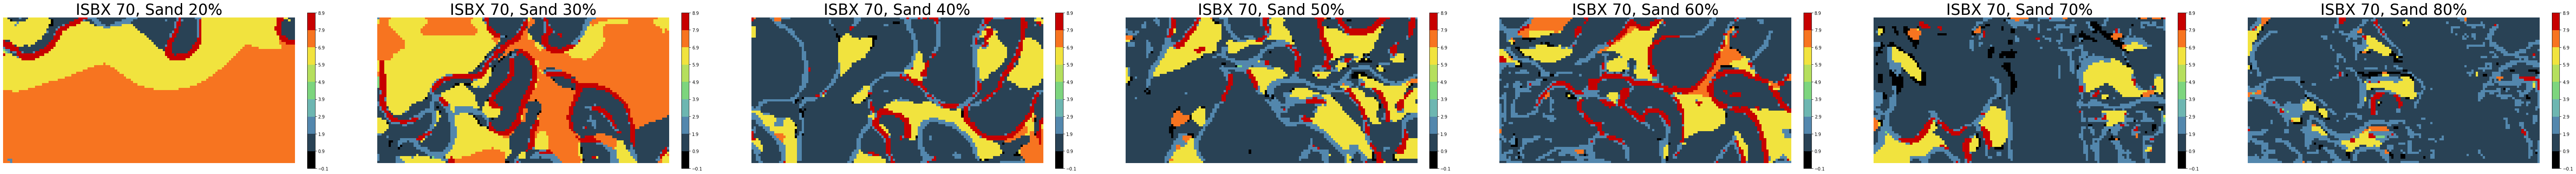

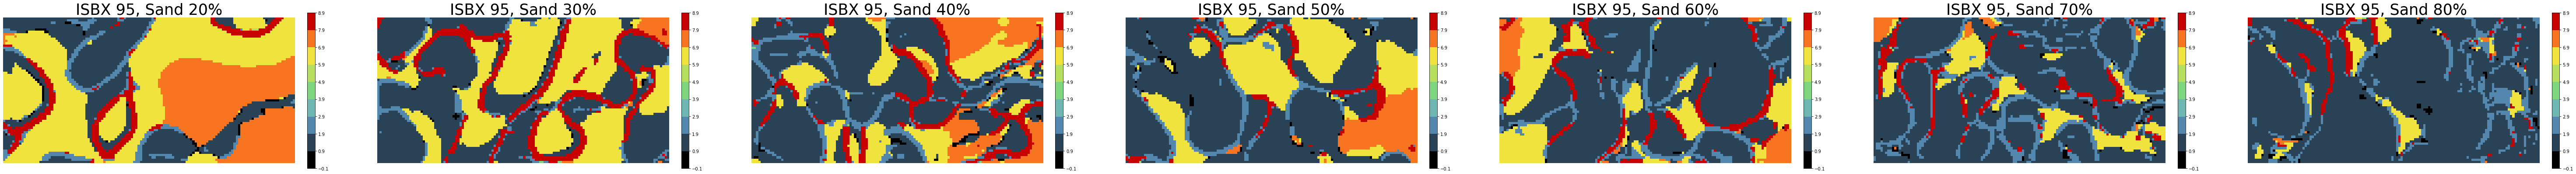

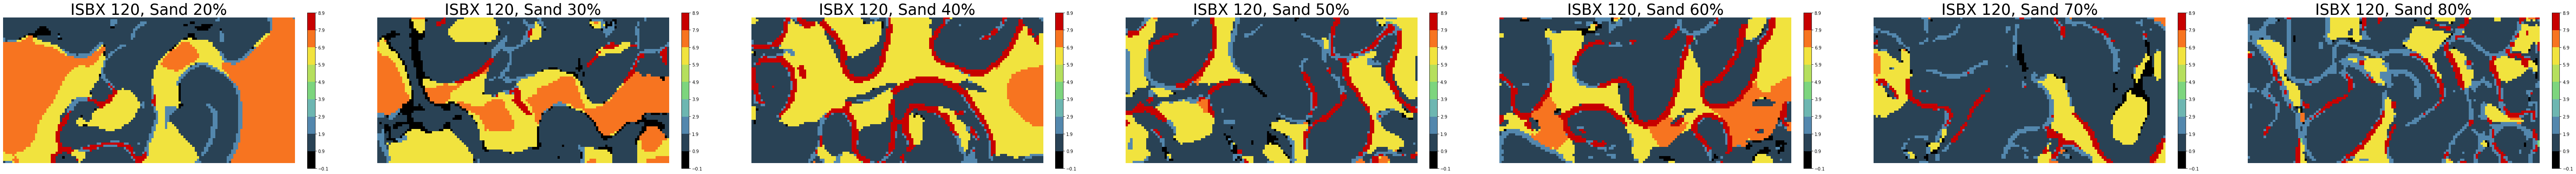

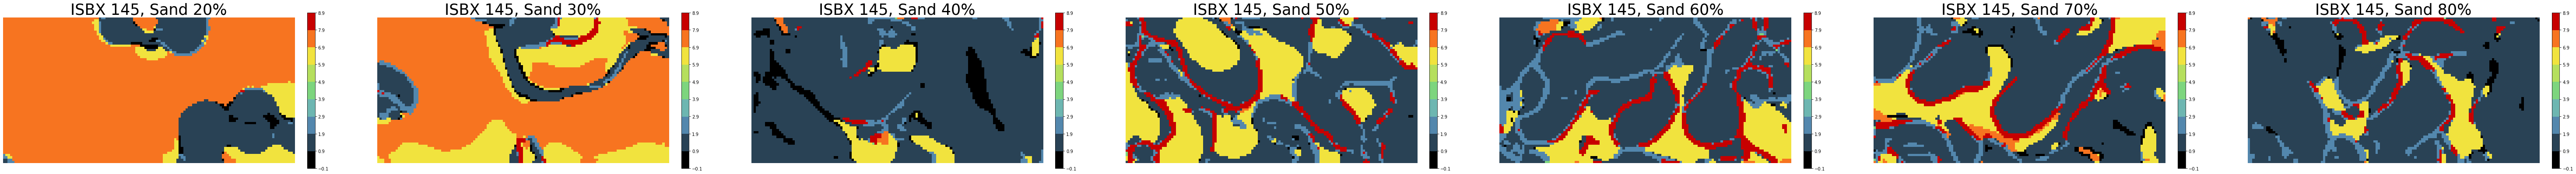

In [40]:
isbx_values = range(20, 160, 25)
sand_values = range(20, 90, 10)

noise_shape = (8, 16)


seed = None

for isbx in isbx_values:
    # Maybe add random normal noise to isbx and sand ?
    plt.figure(figsize=(120, 40))
    for i, sand in enumerate(sand_values):
        y_test = np.array([isbx, sand])
        y_test = np.expand_dims(y_test, axis=0)

        random_latent_vectors = generate_noise(1, *noise_shape, 1)
        gen_inputs = (random_latent_vectors, y_test)
        generated_images = g_model(gen_inputs, training=True)

        my_slice = np.argmax(generated_images[-1].numpy(), axis=-1).reshape((64, 128))

        #arr_flat = my_slice.flatten()
        #ufacies = np.unique(arr_flat)
        # print("Unique facies are ", ufacies)
        #nfacies = len(ufacies) 
        
        plt.subplot(1, len(sand_values) + 1, i + 1)
        plt.gca().set_title('ISBX {}, Sand {}%'.format(isbx, sand), fontsize=35)
        plt.axis('off')
        plt.rcParams["figure.figsize"] = (12,12)
        plt.imshow(my_slice, interpolation='nearest', cmap=cmap, norm=norm)
        plt.colorbar(fraction=0.025, pad=0.04)
plt.show()

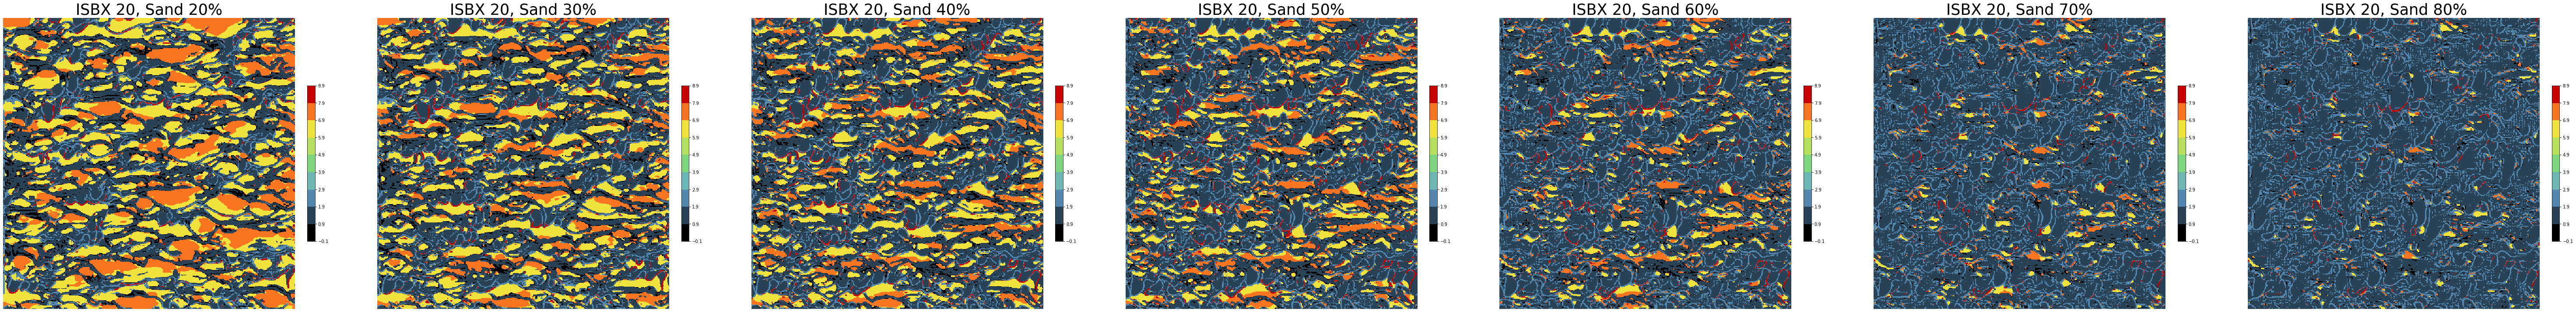

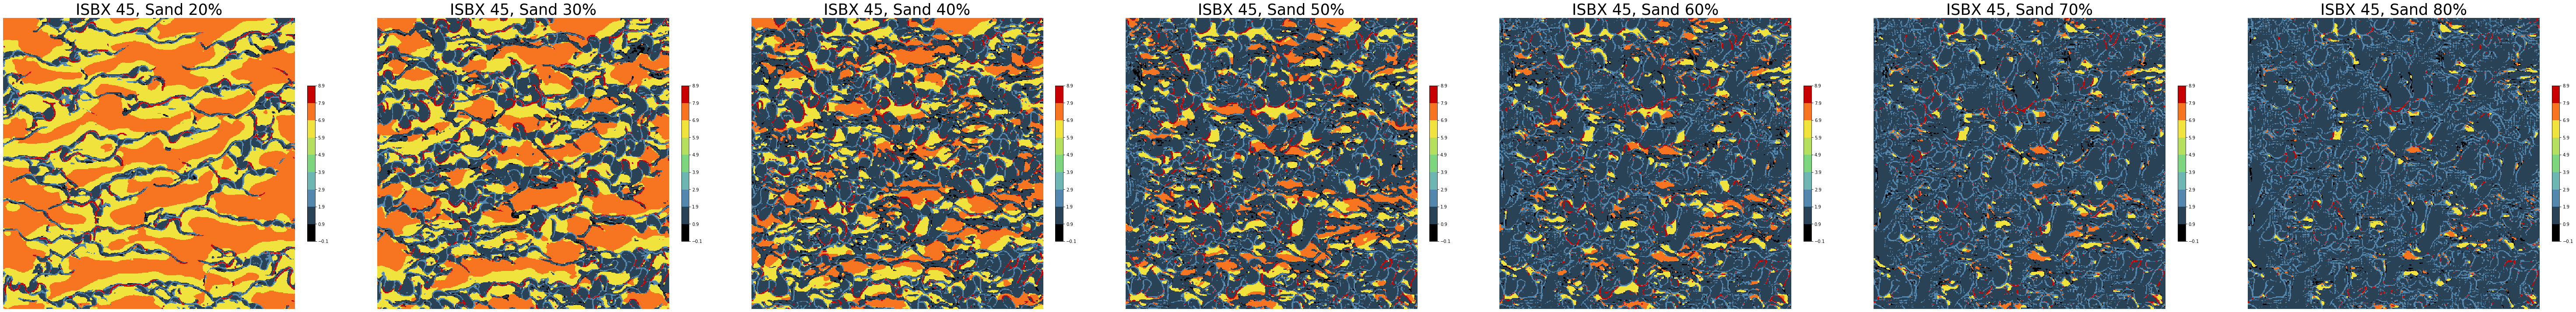

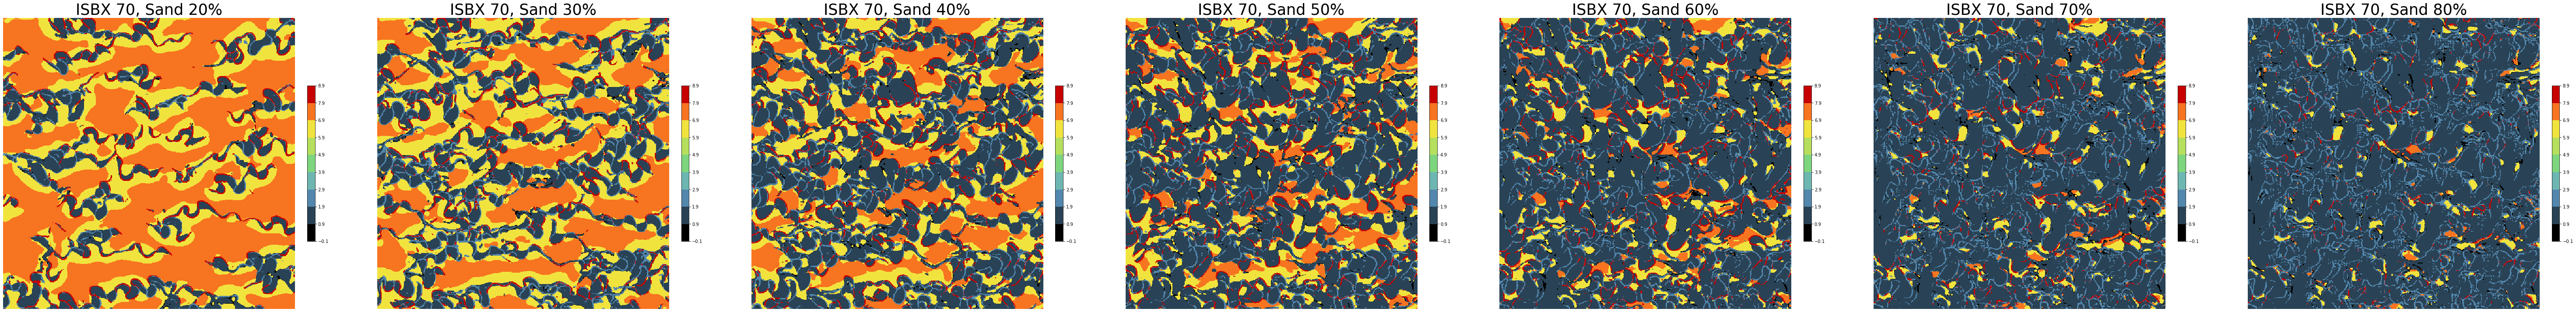

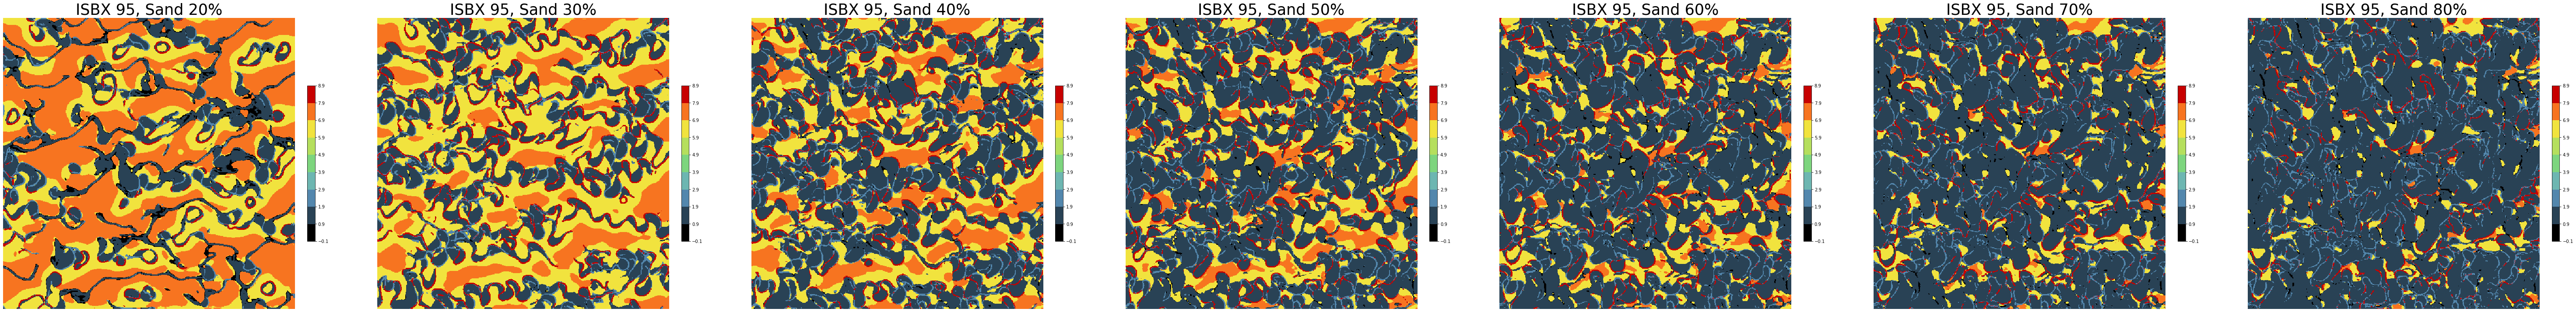

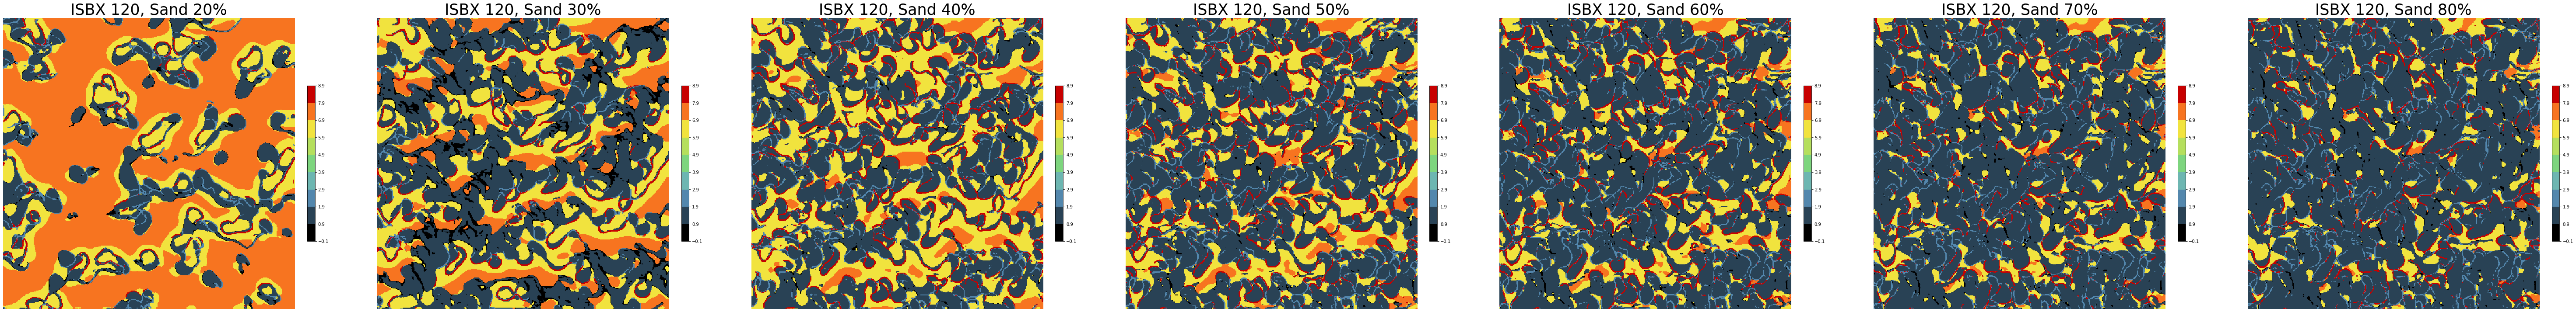

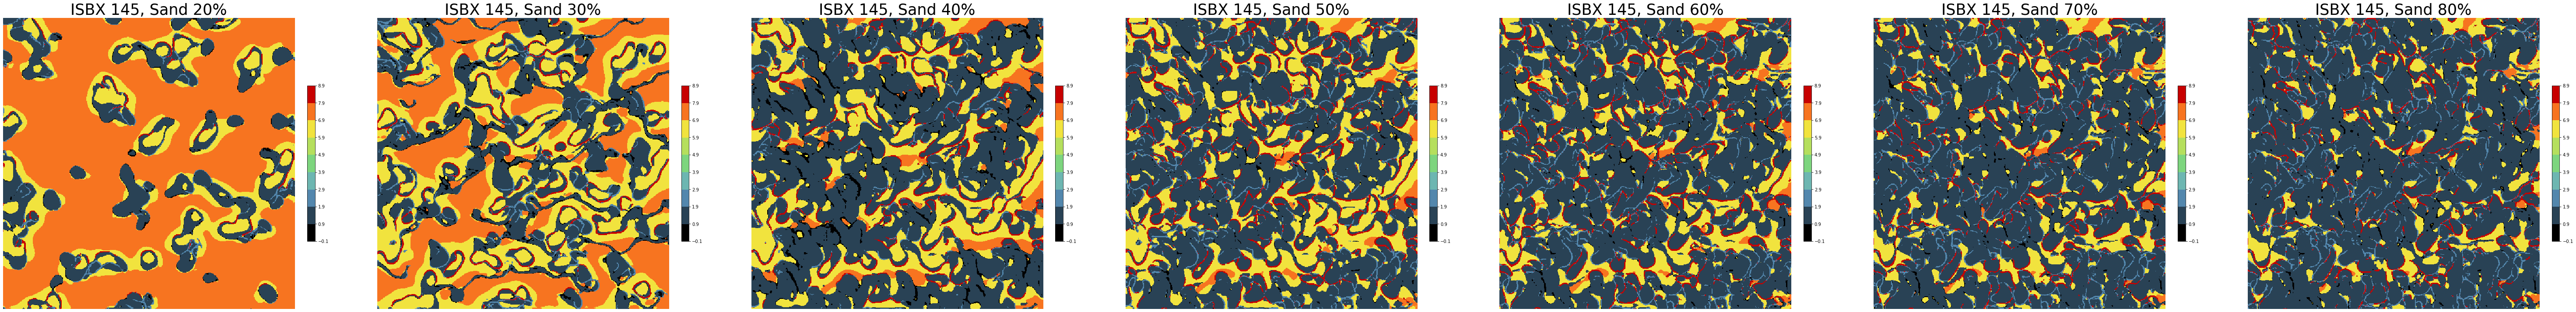

In [36]:
isbx_values = range(20, 160, 25)
sand_values = range(20, 90, 10)

seed = None
noise_shape = (64, 64)
random_latent_vectors = generate_noise(1, *noise_shape, 1)
for isbx in isbx_values:
    # Maybe add random normal noise to isbx and sand ?
    plt.figure(figsize=(120, 40))
    for i, sand in enumerate(sand_values):
        y_test = np.array([isbx, sand])
        y_test = np.expand_dims(y_test, axis=0)

        
        gen_inputs = (random_latent_vectors, y_test)
        generated_images = g_model(gen_inputs, training=True)

        my_slice = np.argmax(generated_images[-1].numpy(), axis=-1).reshape((512, 512))

        #arr_flat = my_slice.flatten()
        #ufacies = np.unique(arr_flat)
        # print("Unique facies are ", ufacies)
        #nfacies = len(ufacies) 
        
        plt.subplot(1, len(sand_values) + 1, i + 1)
        plt.gca().set_title('ISBX {}, Sand {}%'.format(isbx, sand), fontsize=35)
        plt.axis('off')
        plt.rcParams["figure.figsize"] = (12,12)
        plt.imshow(my_slice, interpolation='nearest', cmap=cmap, norm=norm)
        plt.colorbar(fraction=0.025, pad=0.04)
plt.show()

In [31]:

print("Res 1")
random_latent_vectors = generate_noise(1, 24, 32, 1)
generated_images = g_model(random_latent_vectors, training=True)
show_multi_scale_images_and_probas(generated_images, cmap=cmap, norm=norm)

print("Res 2")
random_latent_vectors = generate_noise(1, 16, 32, 1)
generated_images = g_model(random_latent_vectors, training=True)
show_multi_scale_images_and_probas(generated_images, cmap=cmap, norm=norm)

print("Res 3")
random_latent_vectors = generate_noise(1, 64, 64, 1)
generated_images = g_model(random_latent_vectors, training=True)
show_multi_scale_images_and_probas(generated_images, cmap=cmap, norm=norm)

print("Res 4")
random_latent_vectors = generate_noise(1, 8, 50, 1)
generated_images = g_model(random_latent_vectors, training=True)
show_multi_scale_images_and_probas(generated_images, cmap=cmap, norm=norm)

Res 1


InvalidArgumentError: ignored

In [ ]:
import os

SAVE_AND_TAR_RESULTS_WEIGHTS = True

if SAVE_AND_TAR_RESULTS_WEIGHTS:
  msgan_checkpoint_path = "msgan_weights_horizontal_good/cp-msgan2d_horizontal_good.ckpt"
  msgan_checkpoint_dir = os.path.dirname(msgan_checkpoint_path)

  msgan.save_weights(msgan_checkpoint_path)

  !tar -czvf msgan_weights_horizontal_good.tar.gz ./msgan_weights_horizontal_good

  gen_checkpoint_path = "gen_weights_horizontal_good/cp-gen2d_horizontal_good.ckpt"
  gen_checkpoint_dir = os.path.dirname(gen_checkpoint_path)

  msgan.generator.save_weights(gen_checkpoint_path)

  !tar -czvf gen_weights_horizontal_good.tar.gz ./gen_weights_horizontal_good